In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import string
import math

print(tf.__version__)
np.set_printoptions(precision=3, suppress=True)

2.10.0


Obtenir les données

In [33]:
MAX_SIZE = 783
NUM_WORDS = 1000
CHUNKSIZE = 100000
NUM_EPOCHS = 10
EMBEDDING_DIM = 16
EPOCHS = 10
BATCH_SIZE = 512
LOG_DIR = "src/tensorboard"
OOV = 0
SARCASM_TRAINING_SIZE = 20000

def tokenizer_func(data_rating, data_review):
    tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV)
    tokenizer.fit_on_texts(data_review)

    word_index = tokenizer.word_index

    train_labels = data_rating.iloc[math.floor(int(len(data_rating) / 8)):]
    train_examples = data_review.iloc[math.floor(int(len(data_review) / 8)):]
    test_examples = data_review.iloc[:math.floor(int(len(data_review) / 8))]
    test_labels = data_rating.iloc[:math.floor(int(len(data_rating) / 8))]

    sequences_train = tokenizer.texts_to_sequences(train_examples)
    sequences_test = tokenizer.texts_to_sequences(test_examples)

    padded_train = pad_sequences(sequences_train, padding='post', truncating='post', maxlen=MAX_SIZE)
    padded_test = pad_sequences(sequences_test, padding='post', truncating='post', maxlen=MAX_SIZE)

    return np.array(padded_train), np.array(padded_test), np.array(train_labels), np.array(test_labels)

In [34]:
url_train_with_reading_time_NaN = 'src/data/initial/goodreads_train_with_reading_time_NaN.csv'
url_train_with_reading_time = 'src/data/initial/goodreads_train_with_reading_time.csv'
url_train_not_reading_time = 'src/data/initial/goodreads_train_not_reading_time.csv'

raw_dataset = pd.read_csv(url_train_with_reading_time_NaN, 
                          na_values='?', sep=',')

# Solution 1 / ne marche pas
# raw_dataset = raw_dataset.replace('a','1', regex=True)
# raw_dataset = raw_dataset.replace('b','2', regex=True)
# raw_dataset = raw_dataset.replace('c','3', regex=True)
# raw_dataset = raw_dataset.replace('d','4', regex=True)
# raw_dataset = raw_dataset.replace('e','5', regex=True)
# raw_dataset = raw_dataset.replace('f','6', regex=True)
# raw_dataset = raw_dataset.replace('g','7', regex=True)
# raw_dataset = raw_dataset.replace('h','8', regex=True)
# raw_dataset = raw_dataset.replace('i','9', regex=True)
# raw_dataset = raw_dataset.replace('j','10', regex=True)
# raw_dataset = raw_dataset.replace('k','11', regex=True)
# raw_dataset = raw_dataset.replace('l','12', regex=True)
# raw_dataset = raw_dataset.replace('m','13', regex=True)
# raw_dataset = raw_dataset.replace('n','14', regex=True)
# raw_dataset = raw_dataset.replace('o','15', regex=True)
# raw_dataset = raw_dataset.replace('p','16', regex=True)
# raw_dataset = raw_dataset.replace('q','17', regex=True)
# raw_dataset = raw_dataset.replace('r','18', regex=True)
# raw_dataset = raw_dataset.replace('s','19', regex=True)
# raw_dataset = raw_dataset.replace('t','20', regex=True)
# raw_dataset = raw_dataset.replace('u','21', regex=True)
# raw_dataset = raw_dataset.replace('v','22', regex=True)
# raw_dataset = raw_dataset.replace('w','23', regex=True)
# raw_dataset = raw_dataset.replace('x','24', regex=True)
# raw_dataset = raw_dataset.replace('y','25', regex=True)
# raw_dataset = raw_dataset.replace('z','26', regex=True)

# Solution 2 / ne marche pas
# for char in list(string.ascii_lowercase):
#     print(char, type(ord(char)))
#     raw_dataset = raw_dataset.replace(char, ord(char), regex=True)
#     print(raw_dataset.tail())
# raw_dataset = raw_dataset.astype(float)

# Solution 3 / marche mais pas sue tout le data set
# df_mask=raw_dataset['rating']==2
# filtered_df = raw_dataset[df_mask]

# raw_dataset2 = pd.get_dummies(filtered_df['review_id'])
# print(raw_dataset2.tail())

# Solution 4 / marche mais pas les id les book
raw_dataset = raw_dataset.drop(['review_id'], axis=1) 

df_test = tokenizer_func(raw_dataset['rating'], raw_dataset["review_text"])
print(df_test)
dataset = raw_dataset.copy()
print(dataset.tail())

(array([[  2,   1, 234, ...,   2,  73, 147],
       [ 20,  88,  34, ...,   0,   0,   0],
       [ 46,  10,  87, ...,   0,   0,   0],
       ...,
       [386,   1, 256, ...,   0,   0,   0],
       [  4, 409,   4, ...,   0,   0,   0],
       [206,   1,  33, ...,   0,   0,   0]]), array([[  4,  44,  13, ...,   0,   0,   0],
       [  4, 155,   8, ...,   0,   0,   0],
       [137, 137,   5, ...,   0,   0,   0],
       ...,
       [225,  61,   6, ...,   0,   0,   0],
       [  4,  31,  13, ...,   0,   0,   0],
       [  4,   1, 137, ...,   0,   0,   0]]), array([5, 5, 5, ..., 0, 4, 5], dtype=int64), array([5, 5, 5, ..., 4, 3, 4], dtype=int64))
        rating                                        review_text  \
899995       5  O. M. G. \n I need to think about this. Da'am....   
899996       5  A perfect morning. A perfect husband. A perfec...   
899997       0  LIVE! | AMZ US | AMZ UK | B&N | KOBO | iBOOKS ...   
899998       4  I guess I needed a good cry because wow. The G...   
899999  

Nettoyer les données

In [3]:
# suppretion des valeurs vides
dataset = dataset.dropna()

print(dataset.tail())

        rating  reading_time  localisation
899993       4           4.0          -700
899994       5           2.0          -700
899995       5           4.0          -700
899998       4           4.0          -700
899999       5           1.0          -700


Diviser les données en train et test

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Séparer la valeur rechercher

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('rating')
test_labels = test_features.pop('rating')

Normalisation des données

In [6]:
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features)) # .values.astype(np.float32)

normalizer.mean.numpy()

# first = np.array(train_features[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

array([[  11.507, -732.904]], dtype=float32)

Régression linéaire

In [7]:
# affichage entrainement 
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [8]:
# Modele
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 8
Trainable params: 3
Non-trainable params: 5
_________________________________________________________________


Epoch 1/10


C:\Users\tomcareghi\.conda\envs\DeepLearning\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


12310/12310 [==============================] - 62s 5ms/step - loss: 0.8354 - val_loss: 0.8297
Epoch 2/10
12310/12310 [==============================] - 53s 4ms/step - loss: 0.8315 - val_loss: 0.8402
Epoch 3/10
12310/12310 [==============================] - 55s 4ms/step - loss: 0.8318 - val_loss: 0.8184
Epoch 4/10
12310/12310 [==============================] - 54s 4ms/step - loss: 0.8318 - val_loss: 0.8859
Epoch 5/10
12310/12310 [==============================] - 56s 5ms/step - loss: 0.8319 - val_loss: 0.8344
Epoch 6/10
12310/12310 [==============================] - 52s 4ms/step - loss: 0.8314 - val_loss: 0.8177
Epoch 7/10
12310/12310 [==============================] - 54s 4ms/step - loss: 0.8314 - val_loss: 0.8445
Epoch 8/10
12310/12310 [==============================] - 55s 4ms/step - loss: 0.8320 - val_loss: 0.8304
Epoch 9/10
12310/12310 [==============================] - 53s 4ms/step - loss: 0.8321 - val_loss: 0.8263
Epoch 10/10
12310/12310 [==============================] - 54s 4ms

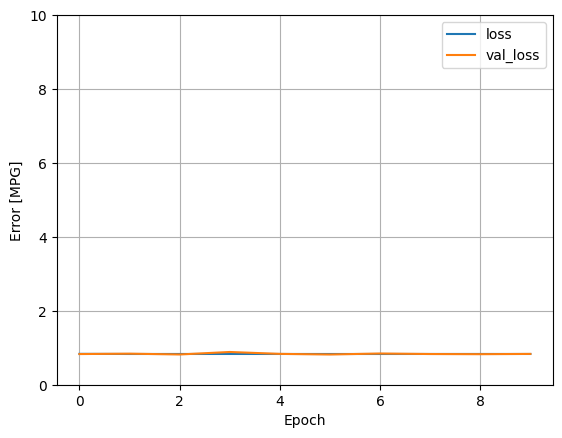

In [9]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
plot_loss(history)

In [10]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

MLP

In [11]:
# Model
mlp_model = keras.Sequential([
  normalizer,
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(5)
])

mlp_model.compile(loss='mean_absolute_error',
            optimizer=tf.keras.optimizers.Adam(0.001))
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                192       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


Epoch 1/10


C:\Users\tomcareghi\.conda\envs\DeepLearning\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


12310/12310 [==============================] - 67s 5ms/step - loss: 0.8306 - val_loss: 0.8223
Epoch 2/10
12310/12310 [==============================] - 66s 5ms/step - loss: 0.8200 - val_loss: 0.8191
Epoch 3/10
12310/12310 [==============================] - 67s 5ms/step - loss: 0.8194 - val_loss: 0.8133
Epoch 4/10
12310/12310 [==============================] - 65s 5ms/step - loss: 0.8187 - val_loss: 0.8170
Epoch 5/10
12310/12310 [==============================] - 65s 5ms/step - loss: 0.8182 - val_loss: 0.8141
Epoch 6/10
12310/12310 [==============================] - 66s 5ms/step - loss: 0.8179 - val_loss: 0.8146
Epoch 7/10
12310/12310 [==============================] - 66s 5ms/step - loss: 0.8176 - val_loss: 0.8184
Epoch 8/10
12310/12310 [==============================] - 66s 5ms/step - loss: 0.8173 - val_loss: 0.8268
Epoch 9/10
12310/12310 [==============================] - 66s 5ms/step - loss: 0.8174 - val_loss: 0.8189
Epoch 10/10
12310/12310 [==============================] - 65s 5ms

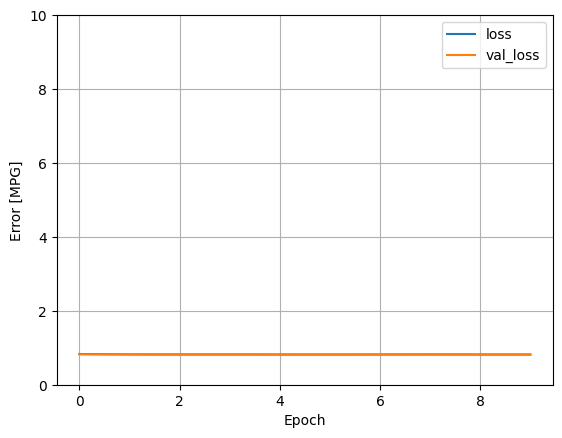

In [12]:
history = mlp_model.fit(
    train_features, #.values.astype(np.float32)
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=10)
plot_loss(history)

In [13]:
test_results['mlp_model'] = mlp_model.evaluate(test_features, test_labels, verbose=0)

In [14]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

Mean absolute error [MPG]
linear_model                   0.832467
mlp_model                      0.814036

Prédiction

3847/3847 [==============================] - 5s 1ms/step


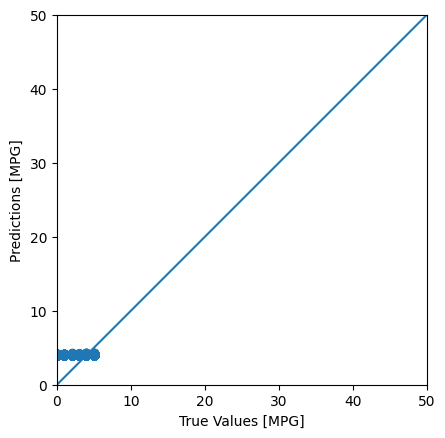

In [15]:
test_predictions_linear = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_linear)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

3847/3847 [==============================] - 7s 2ms/step


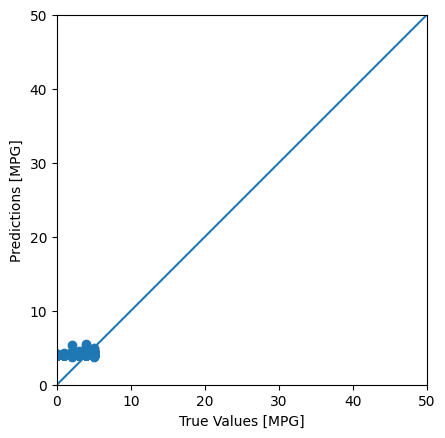

In [16]:
test_predictions_mlp = mlp_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_mlp)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

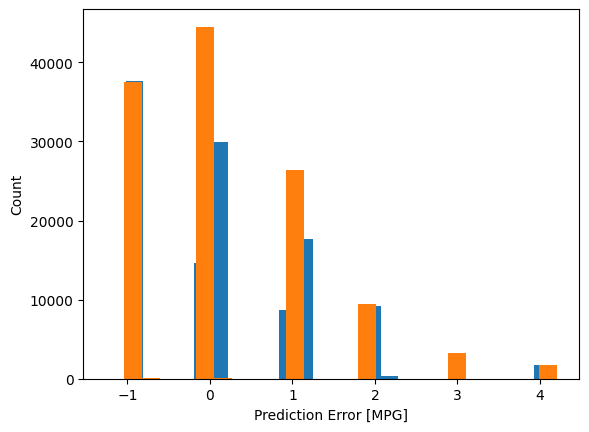

In [17]:
# distribution des erreurs

error_linear = test_predictions_linear - test_labels
plt.hist(error_linear, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

error_mlp = test_predictions_mlp - test_labels
plt.hist(error_mlp, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [18]:
# Save
linear_model.save('linear_model')
mlp_model.save('mlp_model')

INFO:tensorflow:Assets written to: linear_model\assets
INFO:tensorflow:Assets written to: mlp_model\assets


In [11]:
# utiliser

url_test_with_reading_time_NaN = 'src/data/initial/goodreads_test_with_reading_time_NaN.csv'
url_test_with_reading_time = 'src/data/initial/goodreads_test_with_reading_time.csv'
url_test_not_reading_time = 'src/data/initial/goodreads_test_not_reading_time.csv'

raw_dataset_test = pd.read_csv(url_test_with_reading_time_NaN, 
                          na_values='?', sep=',')

raw_dataset_test = raw_dataset_test.drop(['review_id'], axis=1) 
dataset_test = raw_dataset_test.copy()

# dataset_test = dataset_test.dropna()

reloaded = tf.keras.models.load_model('mlp_model')

test_predictions = reloaded.predict(dataset_test)
# print(test_predictions)

# test_results['reloaded'] = reloaded.evaluate(
#     test_features_test, test_labels_test, verbose=0)

14939/14939 [==============================] - 28s 2ms/step


In [18]:
for i in test_predictions:
    if not math.isnan(i[0]):
        print(i[0])
    else:
        print('nn')

3.9957943
3.989938
4.0099196
4.0094614
nn
nn
4.0098276
nn
nn
nn
nn
nn
4.0090036
3.995684
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
4.0098276
3.995242
4.0091867
4.009736
4.009736
nn
nn
4.0096445
4.0099196
4.0099196
nn
nn
4.0058
nn
nn
3.9950209
nn
nn
nn
4.009553
nn
4.0076303
nn
nn
4.00818
nn
nn
nn
4.0091867
nn
nn
nn
4.0030537
nn
nn
4.0100107
nn
4.0098276
nn
4.0090036
4.009553
nn
3.995684
4.0098276
4.009736
4.0098276
4.0098276
4.00818
3.9949107
4.008546
nn
nn
nn
4.0100107
3.9947999
nn
4.008271
nn
4.0100107
4.0099196
nn
nn
3.9930756
nn
nn
4.0096445
nn
nn
3.9957943
nn
4.0100107
nn
3.9954631
nn
3.9949107
nn
nn
nn
nn
nn
nn
4.008546
nn
nn
3.995242
nn
nn
nn
3.994358
nn
nn
nn
nn
3.9959052
4.0099196
4.0094614
nn
nn
4.009736
nn
4.0100107
nn
4.008821
nn
nn
4.0098276
nn
4.0098276
4.0094614
4.009553
4.0090036
4.1027455
4.009736
3.9955735
3.995684
4.0098276
4.009095
4.0093703
nn
4.0099196
nn
4.0094614
4.0072646
4.0098276
3.9950209
3.9953525
4.0099196
4.008455
nn
nn
nn
3.994358
nn
4.0098276
4.0099196
3.9933636
nn


nn
nn
4.0098276
nn
4.007723
3.9951315
nn
nn
4.0096445
3.9951315
4.0067153
nn
4.00818
4.0094614
4.0076303
4.0093703
nn
4.0096445
nn
nn
nn
nn
3.9941368
nn
nn
4.009736
nn
3.995684
4.0092783
4.009095
nn
4.00818
nn
nn
nn
4.009553
3.9957943
4.0099196
4.0098276
4.0099196
nn
nn
nn
3.9959052
3.9900486
nn
4.0100107
3.995242
nn
nn
nn
nn
nn
nn
4.0068984
4.007723
nn
nn
4.0093703
nn
3.9924793
nn
4.0100107
nn
4.0100107
3.9959052
3.994358
nn
nn
nn
4.0094614
nn
3.9957943
4.0092783
nn
4.0100107
nn
nn
4.0100107
nn
nn
nn
nn
nn
nn
nn
4.0098276
4.0091867
nn
4.0099196
4.0094614
nn
nn
3.9957943
nn
4.009736
4.0099196
3.995684
4.0098276
3.9810102
nn
nn
nn
4.0087295
4.0090036
nn
4.0098276
3.9952722
3.9954631
3.9955735
4.0096445
3.9957943
4.00461
nn
4.0100107
4.009736
4.0096445
nn
4.0093703
4.0094614
4.0098276
4.0089126
nn
4.009736
nn
nn
4.0087295
4.0064406
3.9949107
3.995242
3.995242
3.994358
nn
nn
3.9944687
nn
4.0098276
3.993474
3.9942474
nn
4.0093703
4.0096445
4.008271
3.9944687
4.008455
4.0099196
4.006532
4.0

nn
3.9957943
4.0100107
nn
nn
4.0094614
4.0050673
3.9947999
nn
4.0099196
4.0099196
nn
4.009736
3.9950209
4.0098276
nn
3.9957943
3.9957943
3.9875073
nn
4.0099196
3.9949107
3.9957943
4.0096445
4.0096445
3.995684
nn
3.9912646
3.9959052
nn
3.9950209
3.9951315
nn
nn
nn
nn
nn
4.0098276
4.0092783
3.9955735
3.9957943
3.9949107
4.0094614
nn
nn
3.9957943
3.9957943
4.0090036
4.0098276
4.0100107
3.995242
4.0100107
4.0092783
4.0092783
3.9957943
nn
4.0083632
nn
3.9954631
3.9955735
3.9942474
nn
4.0100107
3.995684
3.9957943
4.0094614
nn
3.995684
nn
4.0098276
4.0074477
4.0090036
3.9950209
nn
nn
4.0098276
3.995684
4.0089126
4.009553
nn
4.0098276
4.0099196
nn
3.995242
nn
4.0098276
4.008546
nn
4.0100107
4.0092783
4.0098276
3.9957943
nn
nn
4.0098276
3.995242
nn
3.995684
nn
nn
nn
4.0079966
nn
nn
nn
nn
4.0099196
4.0099196
3.9955735
4.0091867
3.9957943
nn
3.9949107
4.009553
4.009736
3.9957943
nn
4.0100107
4.0099196
nn
4.0098276
4.0099196
nn
4.0093703
4.0098276
3.995684
4.0014057
3.995684
3.9959052
3.9953525
4.

3.9955735
nn
nn
4.0098276
nn
nn
4.0100107
3.992811
4.007173
3.988612
3.995684
nn
4.009736
4.009095
4.0096445
nn
4.009736
3.993916
nn
4.0093703
4.0096445
nn
nn
4.0098276
3.9957943
nn
3.9957943
4.0089126
nn
3.9949107
4.0099196
nn
nn
nn
4.0098276
4.0099196
4.0100107
4.0099196
nn
nn
4.0090036
nn
4.0090036
nn
4.0099196
nn
4.0089126
nn
4.0098276
4.0100107
4.0090036
nn
4.0099196
4.0098276
4.0100107
4.009736
3.9953525
nn
3.9954631
nn
4.0100107
4.0096445
3.9955735
nn
nn
nn
3.9959052
4.0092783
3.9949107
nn
4.0099196
4.009553
4.0094614
nn
4.0098276
4.0098276
4.0100107
4.0096445
4.0099196
3.9955735
nn
4.0099196
nn
4.0100107
3.995684
4.0094614
nn
3.995242
4.0100107
4.0099196
3.9954631
4.0099196
4.0100107
nn
nn
nn
3.9946892
nn
nn
4.0098276
4.0100107
nn
nn
nn
nn
4.0100107
nn
4.0100107
nn
nn
3.9957943
3.9957943
3.9955735
4.0096445
3.995242
nn
4.0098276
4.009553
4.0096445
nn
4.009553
4.0096445
3.994358
4.0078135
4.0089126
3.9953525
nn
4.0091867
4.009736
4.009553
4.0090036
nn
4.0096445
4.0098276
3.99446

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

